   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

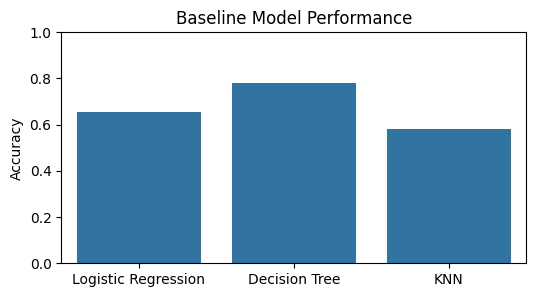

==Logistic Regression Performance ==
              precision    recall  f1-score   support

           3       0.88      1.00      0.94        73
           4       0.62      0.64      0.63        73
           5       0.55      0.51      0.53        72
           6       0.41      0.35      0.38        72
           7       0.61      0.51      0.56        72
           8       0.75      0.89      0.81        73

    accuracy                           0.65       435
   macro avg       0.64      0.65      0.64       435
weighted avg       0.64      0.65      0.64       435

The Confusion Matrix is :
[[73  0  0  0  0  0]
 [ 4 47 13  8  1  0]
 [ 3 14 37 14  3  1]
 [ 2  8 16 25 12  9]
 [ 1  7  1 14 37 12]
 [ 0  0  0  0  8 65]]
precision: 0.6356163017159076
==Decision Tree Performance ==
              precision    recall  f1-score   support

           3       0.96      0.93      0.94        73
           4       0.80      0.89      0.84        73
           5       0.65      0.60      0.62

In [3]:

import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


data = pd.read_csv('/content/WineQT.csv')
print(data.head())

# 3. Data Preparation

print("Missing Values Before Handling:")
print(data.isnull().sum())

df = data.drop_duplicates()

# Handle Class Imbalance using SMOTE
X = data.drop(columns=["quality"])  # Features
y = data["quality"]  # Target variable

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print(y_resampled.value_counts())

# Feature Scaling
scaler = StandardScaler()

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 4. Base Model Building

log_reg = LogisticRegression(max_iter=10000, random_state=42, solver='lbfgs')

# Train the Logistic Regression model
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_reg.predict(X_val_scaled)

# Accuracy
log_acc = accuracy_score(y_val, y_pred_log)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_clf.predict(X_val)

# Accuracy
tree_acc = accuracy_score(y_val, y_pred_tree)
print(f"Decision Tree Accuracy: {tree_acc:.4f}")

# K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_clf.predict(X_val)

# Accuracy
knn_acc = accuracy_score(y_val, y_pred_knn)
print(f"KNN Accuracy: {knn_acc:.4f}")

# Store results
models = ["Logistic Regression", "Decision Tree", "KNN"]
accuracies = [log_acc, tree_acc, knn_acc]

# Plot results
plt.figure(figsize=(6, 3))
sns.barplot(x=models, y=accuracies)
plt.ylabel("Accuracy")
plt.title("Baseline Model Performance")
plt.ylim(0, 1)
plt.show()

# 5. Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"=={model_name} Performance ==")
    print(classification_report(y_true, y_pred, zero_division=1))
    print("The Confusion Matrix is :")
    print(confusion_matrix(y_true, y_pred))
    print("precision:", precision_score(y_true, y_pred, average='macro', zero_division=1))

# Evaluate all models
evaluate_model(y_val, y_pred_log, "Logistic Regression")
evaluate_model(y_val, y_pred_tree, "Decision Tree")
evaluate_model(y_val, y_pred_knn, "K-Nearest Neighbors")

# 6. Hyperparameter Tuning using Grid Search

param_grid_logreg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=10000, solver='lbfgs'), param_grid_logreg, cv=3)
grid_search_logreg.fit(X_train_scaled, y_train)
best_logreg = grid_search_logreg.best_estimator_

# Predictions using best Logistic Regression model
y_val_pred_best_logreg = best_logreg.predict(X_val_scaled)
evaluate_model(y_val, y_val_pred_best_logreg, "Tuned Logistic Regression")

# Decision Tree Classifier Tuning
param_grid_dt = {'max_depth': [2, 4, 6, 9, None], 'min_samples_split': [3, 6, 11]}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_

# Predictions using best Decision Tree model
y_val_pred_best_dt = best_dt.predict(X_val)
evaluate_model(y_val, y_val_pred_best_dt, "Tuned Decision Tree")

# K-Nearest Neighbors Tuning
param_knn = {'n_neighbors': [2, 4, 6, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=3)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_

# Predictions using best KNN model
y_val_pred_best_knn = best_knn.predict(X_val)
evaluate_model(y_val, y_val_pred_best_knn, "Tuned K-Nearest Neighbors")

# 7. Final Model Testing and Evaluation

# Logistic Regression Test Evaluation
y_test_pred_log = best_logreg.predict(X_test_scaled)
print("Test Evaluation for Logistic Regression:")
evaluate_model(y_test, y_test_pred_log, "Logistic Regression")

# Decision Tree Test Evaluation
y_test_pred_tree = best_dt.predict(X_test)
print("Test Evaluation for Decision Tree:")
evaluate_model(y_test, y_test_pred_tree, "Decision Tree")

# KNN Test Evaluation
y_test_pred_knn = best_knn.predict(X_test)
print("Test Evaluation for K-Nearest Neighbors:")
evaluate_model(y_test, y_test_pred_knn, "K-Nearest Neighbors")

